In [17]:
import numpy as np
import random 
from scipy.stats import unitary_group
from scipy.sparse import csr_matrix, kron
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

In [18]:
# defining Pauli matrices & CNOTs
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]] # control tensor switch
CNOT_12_34 = kron(CNOT, CNOT)

data_13_24 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
row_13_24 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
column_13_24 = np.array([0,1,2,3,5,4,7,6,10,11,8,9,15,14,13,12])
CNOT_13_24 = csr_matrix((data_13_24,(row_13_24,column_13_24)), shape =(16,16))

data_14_23 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
row_14_23 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
column_14_23 = np.array([0,1,2,3,6,7,4,5,9,8,11,10,15,14,13,12])
CNOT_14_23 = csr_matrix((data_14_23,(row_14_23,column_14_23)), shape =(16,16))

# defining rotation gates
def Ry(A):
    M = np.array([[np.cos(A/2),-np.sin(A/2)],[np.sin(A/2), np.cos(A/2)]])
    return M
def Rz(A):
    M = np.array([[np.exp(-1j*A/2),0],[0,np.exp(1j*A/2)]])
    return M
    
# Parameterising the general unitary with rotation gates
def U (A0,A1,A2): # Arguments: Euler Angles
    M = Rz(A1)@Ry(A0)@Rz(A2)
    return M

# derivatives wrt A0,A1,A2
def DA0(A0,A1,A2):
    dA0 = (-1j/2)*(Rz(A1)@Y@Ry(A0)@Rz(A2))
    return dA0
def DA1(A0,A1,A2):
    dA1 = (-1j/2)*(Z@Rz(A1)@Ry(A0)@Rz(A2))
    return dA1
def DA2 (A0,A1,A2):
    dA2 = (-1j/2)*(Rz(A1)@Ry(A0)@Z@Rz(A2))
    return dA2

# defining inverse
def inverse(M):
    M_inverse = M.transpose().conjugate()
    return M_inverse
    
def parameters(layers): # layers = number of unitary layers, so no-of CNOTs = layers - 1
    A = np.zeros((4*layers,3))
    for i in range(4*layers):
        for j in range(3):
            A[i][j] = random.uniform(0.0, 4*np.pi) 
    return A
    
def Ulist(layers,A):
    U_list=[]
    for i in range(4*layers):
        Ui = U(A[i][0],A[i][1],A[i][2])
        U_list.append(Ui)
    return U_list

In [19]:
def circuit_structure(A,layers, j, U_goal): # qubit number
    U_list= Ulist(layers,A)
    CNOTS = [CNOT_12_34,CNOT_13_24,CNOT_14_23]
    U_list[j-1] = np.eye(2)  # isolating unitary of interest
    U_kron =[]
    for i in range(0,4*layers,4):
        elt1 = np.kron(U_list[i],U_list[i+1])
        elt2 = np.kron(U_list[i+2],U_list[i+3])
        elt = np.kron(elt1,elt2)
        U_kron.append(elt)
    U_kron = np.array(U_kron)
    q = (j-1) // 4
    Uf = np.eye(16)
    Ub = np.eye(16)
    for it in range(q):
        #print(it)
        Uf = Uf @ U_kron[it] @ CNOTS[it%3]
    #print(q)
    Uf = Uf @ U_kron[q]
    for ib in range(q+1, layers):
        Ub = Ub@ CNOTS[(ib-1)%3] @ U_kron[ib]
    U_tbm = inverse(Uf)@U_goal@inverse(Ub) # U_tbm = rhs , U to be made
    return U_tbm


In [29]:
def gradient_descent(layers,U_goal, A, iterations, alpha):
    nsu = 4*layers #(number of single qubit unitaries)
    #inner_iterations = iterations
    #print(inner_iterations)
    stop_flag=0
    Aopt = np.copy(A) # to separate input and output
    #Uerr_array =[]
    #for i in range(inner_iterations):
        #if stop_flag ==1:
            #print("Truncation")
            #break
    for j in range(1, nsu + 1):
        #print("j =",j)
        # rhs of the optimisation
        Ui = circuit_structure(Aopt, layers, j, U_goal)
         # defining LHS
        A0=Aopt[j-1][0]
        A1=Aopt[j-1][1]
        A2=Aopt[j-1][2]
    
        U_initial= U(A0,A1,A2)
        if j%4 == 1:
            U12 = np.kron(U_initial,np.eye(2))
            U34 = np.eye(4)
            Uxyz = np.kron(U12,U34)
        elif j%4 == 2:
            U12 = np.kron(np.eye(2),U_initial)
            U34 = np.eye(4)
            Uxyz = np.kron(U12,U34)
        elif j%4 == 3:
            U12 = np.eye(4)
            U34 =np.kron(U_initial, np.eye(2))
            Uxyz = np.kron(U12,U34)
        elif j%4 == 0 :
            U12 = np.eye(4)
            U34 =np.kron(np.eye(2),U_initial)
            Uxyz = np.kron(U12,U34)
        for k in range(iterations): # outer iterations
         #defining cost function
            Tr = np.trace(Ui@inverse(Uxyz))
            Abs = np.abs(Tr)
            Uerr = 16 - Abs
            Uerr_array.append(Uerr)
            #print(Uerr)
            if Uerr < 1e-8:
                stop_flag=1
                break
            else:
                #gradient 
                dA0 = DA0(A0,A1,A2)
                dA1 = DA1(A0,A1,A2)
                dA2 = DA2(A0,A1,A2)
            if j%4 == 1:
                UdA0 = np.kron(np.kron(dA0,np.eye(2)), np.eye(4))
                UdA1 = np.kron(np.kron(dA1,np.eye(2)), np.eye(4))
                UdA2 = np.kron(np.kron(dA2,np.eye(2)), np.eye(4))
            elif j%4 == 2:
                UdA0 = np.kron(np.kron(np.eye(2),dA0), np.eye(4))
                UdA1 = np.kron(np.kron(np.eye(2),dA1), np.eye(4))
                UdA2 = np.kron(np.kron(np.eye(2),dA2), np.eye(4))
        
            elif j%4 == 3:
                UdA0 =np.kron(np.eye(4),np.kron(dA0, np.eye(2)))
                UdA1 =np.kron(np.eye(4),np.kron(dA1, np.eye(2)))
                UdA2 =np.kron(np.eye(4),np.kron(dA2, np.eye(2)))
            elif j%4 == 0 :
                UdA0 =np.kron(np.eye(4),np.kron(np.eye(2),dA0))
                UdA1 =np.kron(np.eye(4),np.kron(np.eye(2),dA1))
                UdA2 =np.kron(np.eye(4),np.kron(np.eye(2),dA2))
            Grad_A0 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA0)))
            Grad_A0R = Grad_A0.real
            Grad_A1 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA1)))
            Grad_A1R = Grad_A1.real
            Grad_A2 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA2)))
            Grad_A2R = Grad_A2.real

            #updation
            A0 = A0 - alpha*Grad_A0R
            A1 = A1 - alpha*Grad_A1R
            A2 = A2 - alpha*Grad_A2R
            if j%4 == 1:
                U12 = np.kron(U(A0,A1,A2),np.eye(2))
                U34 = np.eye(4)
                Uxyz = np.kron(U12,U34)
            elif j%4 == 2:
                U12 = np.kron(np.eye(2),U(A0,A1,A2))
                U34 = np.eye(4)
                Uxyz = np.kron(U12,U34)
            elif j%4 == 3:
                U12 = np.eye(4)
                U34 =np.kron(U(A0,A1,A2), np.eye(2))
                Uxyz = np.kron(U12,U34)
            elif j%4 == 0 :
                U12 = np.eye(4)
                U34 =np.kron(np.eye(2),U(A0,A1,A2))
                Uxyz = np.kron(U12,U34)
            Aopt[j-1][0]=A0
            Aopt[j-1][1]=A1
            Aopt[j-1][2]=A2
            if stop_flag==1:
                break
    #return Uerr_array
    return Aopt, stop_flag
                
           
    

In [43]:
layers = 35
U_goal = (unitary_group.rvs(16))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
# truncation condition 
stop_flag=0
Uerr_array =[]
for i in range(1000):
    if i%10==0:
        print("iteration=", i)
    if stop_flag ==1:
        print("Truncation")
        break
    AOpt,stop_flag = gradient_descent(layers,U_goal, AOpt, 10, 0.1)

#Error = gradient_descent(layers,U_goal, AOpt, 1000, 0.1)
#U_tbm=circuit_structure(AOpt, layers, 8, U_goal)
#print(np.shape(U_tbm))
#plt.plot(np.log10(Error))

iteration= 0
iteration= 10
iteration= 20
iteration= 30
iteration= 40
iteration= 50
iteration= 60
iteration= 70
iteration= 80
iteration= 90
iteration= 100
iteration= 110
iteration= 120
iteration= 130
iteration= 140
iteration= 150
iteration= 160
iteration= 170
iteration= 180
iteration= 190
iteration= 200
iteration= 210
iteration= 220
iteration= 230
iteration= 240
iteration= 250
iteration= 260
iteration= 270
iteration= 280
iteration= 290
iteration= 300
iteration= 310
iteration= 320
iteration= 330
iteration= 340
iteration= 350
iteration= 360
iteration= 370
iteration= 380
iteration= 390
iteration= 400
iteration= 410
iteration= 420
iteration= 430
iteration= 440
iteration= 450
iteration= 460
iteration= 470
iteration= 480
iteration= 490
iteration= 500
iteration= 510
iteration= 520
iteration= 530
iteration= 540
iteration= 550
iteration= 560
iteration= 570
iteration= 580
iteration= 590
iteration= 600
iteration= 610
iteration= 620
iteration= 630
iteration= 640
iteration= 650
iteration= 660
iterat

KeyboardInterrupt: 

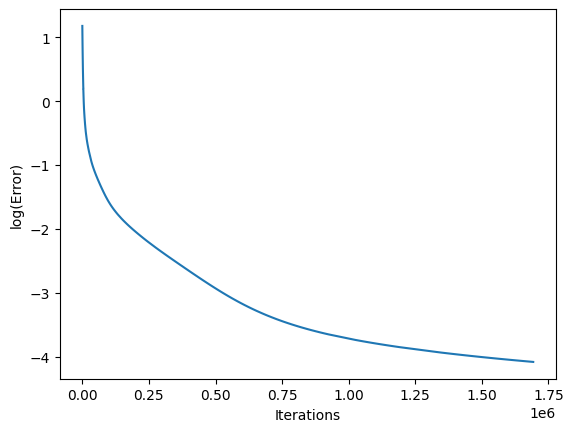

In [44]:
plt.plot(np.log10(Uerr_array))
plt.xlabel("Iterations")
plt.ylabel("log(Error)")
plt.savefig('4 qubit system.png', bbox_inches='tight')

In [94]:

# # function to do gradient descent
# def gradient_descent(A, iterations,alpha,U_goal): # A = array of parameters, alpha - learning rate
#     inner_iterations = int(iterations/10)
#     print(inner_iterations)
#     stop_flag=0
#     Aopt = np.copy(A) # to separate input and output
#     Uerr_array =[]
#     for i in range(inner_iterations):
#         if stop_flag ==1:
#             print("Truncation")
#             break
#         for j in range(1,9):
#             # rhs of the optimization
#             Ui = Utbm(j,Aopt,U_goal)

#             # defining LHS 
#             A0=Aopt[j-1][0]
#             A1=Aopt[j-1][1]
#             A2=Aopt[j-1][2]
        
#             U_initial= U(A0,A1,A2)
#             if j%2!=0:
#                 Uxyz = np.kron(U_initial,np.eye(2))
           
#             else:
#                 Uxyz = np.kron(np.eye(2), U_initial)
            
#             for k in range(10):
#              #defining cost function
#                 Tr = np.trace(Ui@inverse(Uxyz))
#                 Abs = np.abs(Tr)
#                 Uerr = 4 - Abs
#                 Uerr_array.append(Uerr)
#                 if Uerr < 1e-8:
#                     stop_flag=1
#                     break
#                 else:
#                     #gradient 
#                     dA0 = DA0(A0,A1,A2)
#                     dA1 = DA1(A0,A1,A2)
#                     dA2 = DA2(A0,A1,A2)
#                     if j%2!=0:
#                         UdA0 = np.kron(dA0,np.eye(2))
#                         UdA1 = np.kron(dA1,np.eye(2))
#                         UdA2 = np.kron(dA2,np.eye(2))
#                     else:
#                         UdA0 = np.kron(np.eye(2),dA0)
#                         UdA1 = np.kron(np.eye(2),dA1)
#                         UdA2 = np.kron(np.eye(2),dA2)

#                     Grad_A0 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA0)))
#                     Grad_A0R = Grad_A0.real
#                     Grad_A1 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA1)))
#                     Grad_A1R = Grad_A1.real
#                     Grad_A2 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA2)))
#                     Grad_A2R = Grad_A2.real

#                     #updation
#                     A0 = A0 - alpha*Grad_A0R
#                     A1 = A1 - alpha*Grad_A1R
#                     A2 = A2 - alpha*Grad_A2R

#                     if j%2 != 0:
#                         Uxyz = np.kron(U(A0,A1,A2),np.eye(2))
#                     else:
#                         Uxyz = np.kron(np.eye(2), U(A0,A1,A2))
#                     Aopt[j-1][0]=A0
#                     Aopt[j-1][1]=A1
#                     Aopt[j-1][2]=A2
#                 if stop_flag==1:
#                     break
#     return Uerr_array


                
        

In [48]:
import numpy as np
from scipy.sparse import csr_matrix
from itertools import combinations

# Define CNOT gate (control=0, target=1)
CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=complex)

def generate_matchings(qubits):
    if not qubits:
        return [[]]
    matchings = []
    first = qubits[0]
    for i in range(1, len(qubits)):
        pair = (first, qubits[i])
        rest = qubits[1:i] + qubits[i+1:]
        for submatching in generate_matchings(rest):
            matchings.append([pair] + submatching)
    return matchings

def apply_cnot_matrix_on_nqubits(control, target, n):
    """Returns 2^n x 2^n sparse matrix of a single CNOT acting on (control, target)"""
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])

    result = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(2**n):
        b = list(f"{i:0{n}b}")
        if b[control] == '1':
            b[target] = '0' if b[target] == '1' else '1'
        j = int(''.join(b), 2)
        result[j, i] = 1
    return csr_matrix(result)

def build_cnot_matrix_for_matching(matching, n=6):
    U = csr_matrix(np.eye(2**n, dtype=complex))
    for control, target in matching:
        U = apply_cnot_matrix_on_nqubits(control, target, n) @ U
    return U

# Step 1: Generate all 15 matchings
qubits = list(range(6))
matchings = generate_matchings(qubits)
# Sort matchings for consistency
matchings = [sorted([tuple(sorted(pair)) for pair in m]) for m in matchings]
matchings = sorted(matchings)

# Step 2: Build sparse 64x64 unitary matrices for each matching
sparse_matrices = [build_cnot_matrix_for_matching(m) for m in matchings]

# Example: Print the sparsity and some entries from the first sparse matrix
print(f"Sparsity of first matrix: {sparse_matrices[0].nnz}/{sparse_matrices[0].shape[0] * sparse_matrices[0].shape[1]}")
print("First few non-zero elements in the sparse matrix:")
print(sparse_matrices[14])  # Convert to dense to view part of the matrix (for illustration)


Sparsity of first matrix: 64/4096
First few non-zero elements in the sparse matrix:
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 64 stored elements and shape (64, 64)>
  Coords	Values
  (0, 0)	(1+0j)
  (1, 1)	(1+0j)
  (2, 2)	(1+0j)
  (3, 3)	(1+0j)
  (4, 4)	(1+0j)
  (5, 5)	(1+0j)
  (6, 6)	(1+0j)
  (7, 7)	(1+0j)
  (8, 12)	(1+0j)
  (9, 13)	(1+0j)
  (10, 14)	(1+0j)
  (11, 15)	(1+0j)
  (12, 8)	(1+0j)
  (13, 9)	(1+0j)
  (14, 10)	(1+0j)
  (15, 11)	(1+0j)
  (16, 18)	(1+0j)
  (17, 19)	(1+0j)
  (18, 16)	(1+0j)
  (19, 17)	(1+0j)
  (20, 22)	(1+0j)
  (21, 23)	(1+0j)
  (22, 20)	(1+0j)
  (23, 21)	(1+0j)
  (24, 30)	(1+0j)
  :	:
  (39, 38)	(1+0j)
  (40, 45)	(1+0j)
  (41, 44)	(1+0j)
  (42, 47)	(1+0j)
  (43, 46)	(1+0j)
  (44, 41)	(1+0j)
  (45, 40)	(1+0j)
  (46, 43)	(1+0j)
  (47, 42)	(1+0j)
  (48, 51)	(1+0j)
  (49, 50)	(1+0j)
  (50, 49)	(1+0j)
  (51, 48)	(1+0j)
  (52, 55)	(1+0j)
  (53, 54)	(1+0j)
  (54, 53)	(1+0j)
  (55, 52)	(1+0j)
  (56, 63)	(1+0j)
  (57, 62)	(1+0j)
  (58, 61)	(1+0j)
